### Run scrublet on the Harvard nuclei post `cellbender`

- Carlos Talavera-López PhD
- Wellcome Sanger Institite - 191205


### Load required modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

/opt/conda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/opt/conda/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

Running Scanpy 1.4.5.1, on 2020-04-21 12:49.


### Read datasets

In [3]:
heart_nuclei = anndata.read_h5ad('/home/jovyan/experiments/0-generate_anndata_objects/harvard_heart_NucSeq_CellRanger_RAW_ctl200420.h5ad')
heart_nuclei.var_names_make_unique()
heart_nuclei.shape

(201555, 33538)

### Remove empty droplets

In [4]:
sample_object = heart_nuclei.copy()
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1)
sample_object.obs['n_counts'].describe()

count    201555.000000
mean       3601.395264
std        4404.864746
min         500.000000
25%        1317.000000
50%        2307.000000
75%        4475.000000
max      289237.000000
Name: n_counts, dtype: float64

In [5]:
sample_object.shape

(201555, 33538)

### Remove cells or Nuclei with less than 200 genes

In [7]:
sc.pp.filter_cells(data = sample_object, min_genes = 200)
sample_object.shape

(201552, 33538)

### Compute QC stats

In [8]:
sample_object.shape

(201552, 33538)

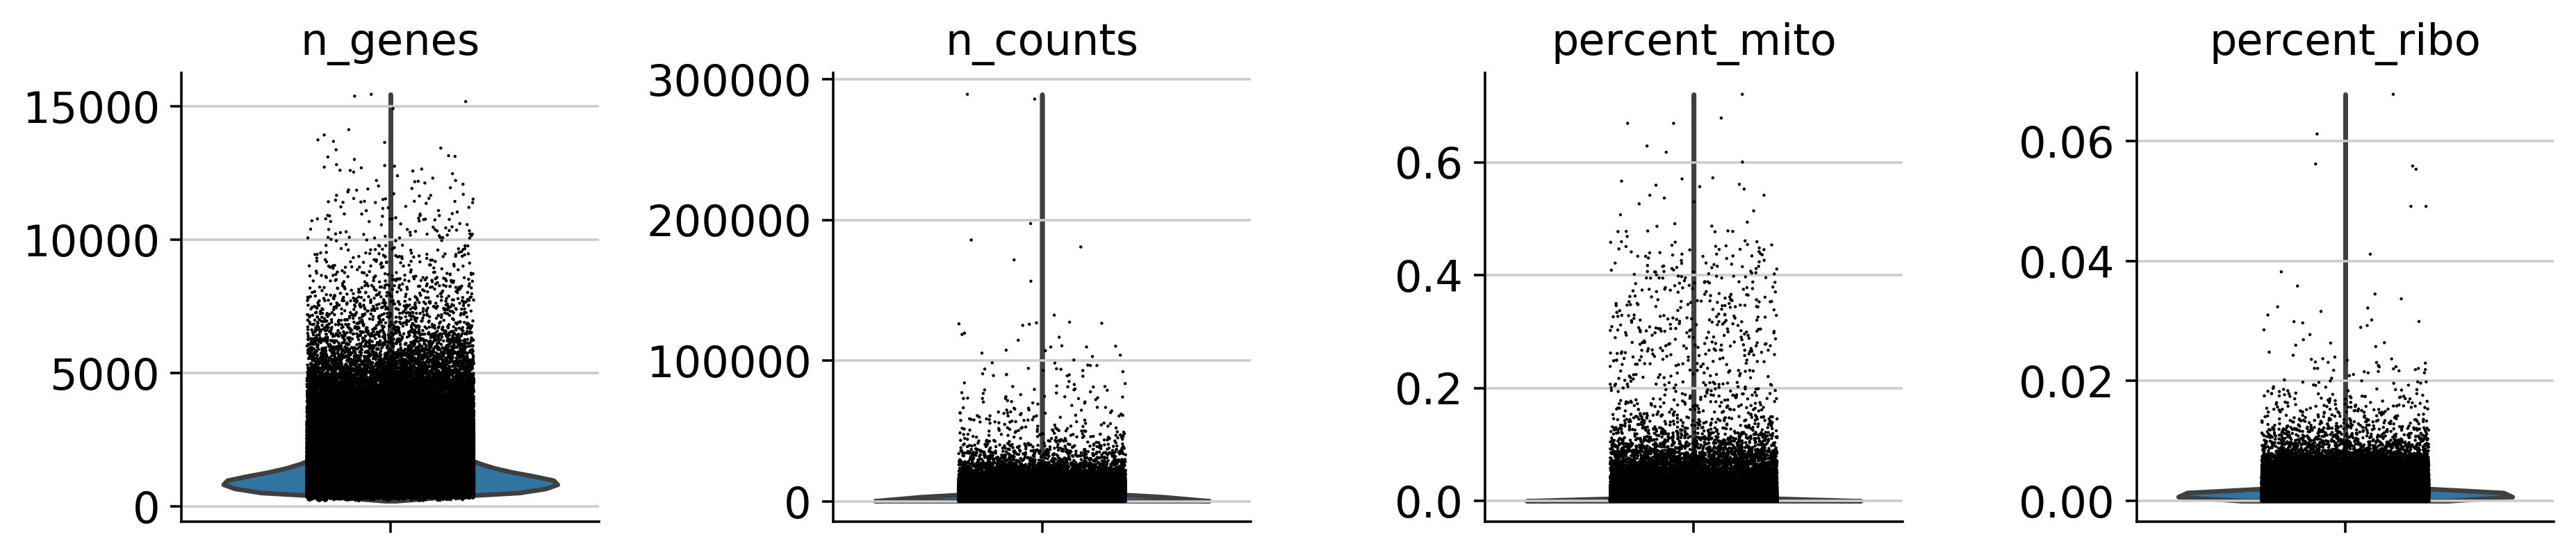

In [9]:
mito_cells = sample_object.var_names.str.startswith('MT-')
ribo_cells = sample_object.var_names.str.startswith('RPS','RPL')
sample_object.obs['percent_mito'] = np.sum(sample_object[:, mito_cells].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sample_object.obs['percent_ribo'] = np.sum(sample_object[:, ribo_cells].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sc.pl.violin(sample_object, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'], jitter = 0.2, multi_panel = True)

### Remove cells/nuclei exceeding the ribo/mito threshold 

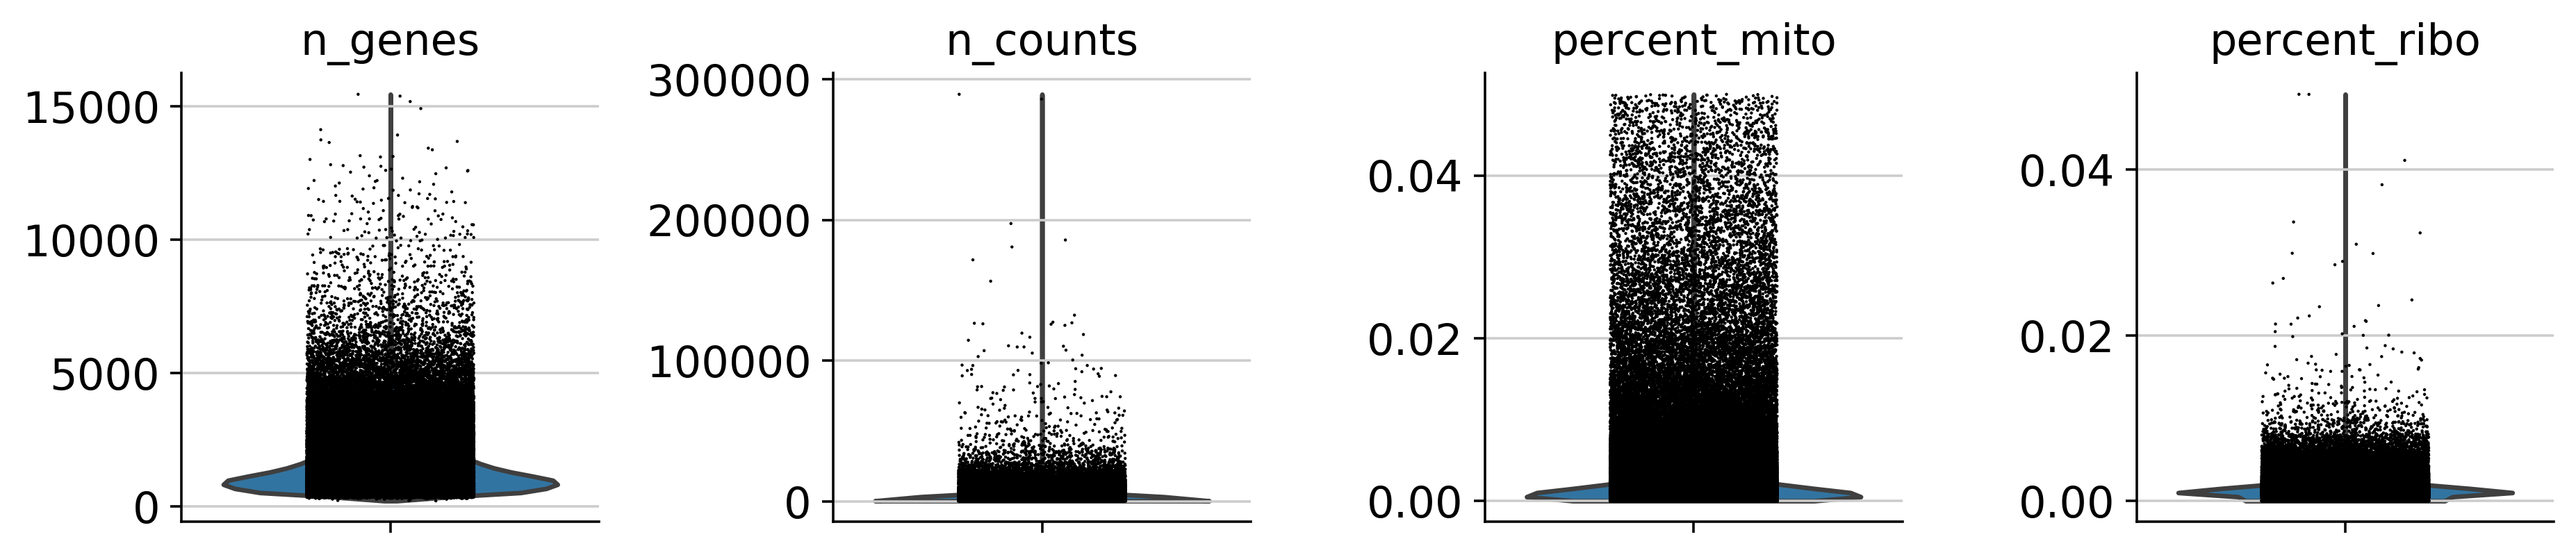

In [10]:
sample_object = sample_object[sample_object.obs['percent_mito'] < 0.05, :]
sample_object = sample_object[sample_object.obs['percent_ribo'] < 0.05, :]
sc.pl.violin(sample_object, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],jitter = 0.2, multi_panel = True)

In [11]:
sample_object.shape

(198443, 33538)

### Create a working copy of the data and process it

In [12]:
sample_object_backup = sample_object.copy()
sc.pp.normalize_per_cell(sample_object, counts_per_cell_after = 1e4)
sc.pp.log1p(sample_object)
sc.pp.highly_variable_genes(sample_object, n_top_genes = 1000)
heart_hvg = sample_object[:, sample_object.var['highly_variable']]
sc.pp.scale(heart_hvg, max_value = 10)
heart_hvg.shape

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:22): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:913: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


(198443, 999)

### Compute PCA

In [13]:
sc.tl.pca(heart_hvg, svd_solver = 'arpack', random_state = 1712)

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:21)


### Identify doublets via scrublets using an AnnData-friendly version

In [14]:
from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix
import numpy as np


def woublet(
        adata,
        sim_doublet_ratio = 2,
        n_neighbors = 30,
        expected_doublet_rate = 0.1,
        total_counts_key = 'n_counts',
        copy = False):
    
    adata = adata.copy() if copy else adata

    if 'X_pca' not in adata.obsm_keys():
        raise ValueError(
            'Did not find \'X_pca\'. Run `sc.pp.pca` first.')

    if total_counts_key in adata.obs:
        total_counts = np.array(adata.obs[total_counts_key])
    else:
        total_counts = np.ones(adata.X.shape[0])

    # Simulate doublets by averaging PC coordinates of random cell pairs
    logg.info('Simulating doublets')
    PCdat, doub_labels, parent_ix = simulate_doublets_from_pca(adata.obsm['X_pca'], 
        total_counts = total_counts, 
        sim_doublet_ratio = sim_doublet_ratio)


    adata_doub = AnnData(csc_matrix((PCdat.shape[0], 1)))
    adata_doub.obsm['X_pca'] = PCdat

    # Calculate doublet scores using k-nearest-neighbor classifier
    logg.info('Running KNN classifier')
    adata.obs['doublet_score'], adata.uns['sim_doublet_score'] = calculate_doublet_scores(
        adata_doub, 
        doub_labels, 
        n_neighbors = n_neighbors, 
        expected_doublet_rate = expected_doublet_rate)

    adata.obs['doublet_score']

    return adata if copy else None



#========================================================================================#

def simulate_doublets_from_pca(PCdat, total_counts=[], sim_doublet_ratio=1):
    '''
    Simulate doublets by averaging PCA coordinates of random cell pairs.
    Average is weighted by total counts of each parent cell, if provided.

    Returns:
    PCdoub (matrix of size (num_cells+num_sim_doubs, num_pcs)): PCA matrix with the simulated doublet PCA coordinates appended to the original data matrix PCdat.
    doub_labels (array of size (num_cells+num_sim_doubs)): 0 if observed cell, 1 if simulated doublet
    pair_ix (matrix of size(num_sim_doubs, 2)): each row gives the indices of the parent cells used to generate the simulated doublet
    '''

    n_obs = PCdat.shape[0]
    n_doub = int(n_obs * sim_doublet_ratio)

    if len(total_counts) == 0:
        total_counts = np.ones(n_obs)

    pair_ix = np.random.randint(0, n_obs, size = (n_doub, 2))

    pair_tots = np.hstack((total_counts[pair_ix[:, 0]][:,None], total_counts[pair_ix[:, 1]][:,None]))
    pair_tots = np.array(pair_tots, dtype=float)
    pair_fracs = pair_tots / np.sum(pair_tots, axis=1)[:,None]

    PCdoub = PCdat[pair_ix[:, 0],:] * pair_fracs[:, 0][:,None] + PCdat[pair_ix[:, 1],:] * pair_fracs[:, 1][:,None]

    PCdoub = np.vstack((PCdat, PCdoub))
    doub_labels = np.concatenate((np.zeros(n_obs), np.ones(n_doub)))

    return PCdoub, doub_labels, pair_ix

#========================================================================================#

def calculate_doublet_scores(adata, doub_labels, n_neighbors=30, expected_doublet_rate = 1.0):
    n_obs = sum(doub_labels == 0)
    n_sim = sum(doub_labels == 1)

    # Adjust k (number of nearest neighbors) based on the ratio of simulated to observed cells
    k_adj = int(round(n_neighbors * (1+n_sim/float(n_obs))))

    # Find k_adj nearest neighbors
    neighbors(adata, n_neighbors = k_adj, use_rep = 'X_pca')

    # Calculate doublet score based on ratio of simulated cell neighbors vs. observed cell neighbors
    matrix = adata.uns['neighbors']['distances']
    n_sim_neigh = (matrix[:,doub_labels == 1]>0).sum(1).A.squeeze()
    n_obs_neigh = (matrix[:,doub_labels == 0]>0).sum(1).A.squeeze()
    
    doub_score = n_sim_neigh / (n_sim_neigh + n_obs_neigh * n_sim / float(n_obs) / expected_doublet_rate)
    doub_score_obs = doub_score[doub_labels == 0]

    # return doublet scores for observed cells and simulated cells
    return doub_score[doub_labels == 0], doub_score[doub_labels == 1]

### Run scrublet on each sample

In [15]:
holder = np.zeros((heart_hvg.shape[0],))
for smp in np.unique(heart_hvg.obs['sample']):
#    if smp == []:
    if any( [smp == 'HCAHeart7728604', smp == 'HCAHeart7728609']):
        continue
    adata_smp = heart_hvg[heart_hvg.obs['sample'] == smp]
    sc.tl.pca(adata_smp, svd_solver = 'arpack', random_state = 1786)
    woublet(adata_smp)
    holder[heart_hvg.obs['sample'] == smp] = adata_smp.obs['doublet_score']
heart_hvg.obs['doublet_score'] = holder

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:05)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:41)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:27)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:34)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:37)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:09)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:51)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:10)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:14)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:16)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:21)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:43)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:23)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:10)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:21)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:11)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:27)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:20)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:12)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:09)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:25)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:27)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:01)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:38)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:13)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:14)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:16)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:31)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:13)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)
Simulating doublets
Running KNN classifier
computing neighbors


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:22)


### Visualise scrublet scores

In [16]:
sc.tl.pca(heart_hvg, svd_solver = 'arpack', random_state = 1712)

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:24)


In [17]:
sc.pp.neighbors(heart_hvg, random_state = 1786)
sc.tl.umap(heart_hvg, min_dist = 0.2, spread = 1, random_state = 1712)

computing neighbors
    using 'X_pca' with n_pcs = 50


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../opt/conda/lib/python3.7/site-packages/umap/nndescent.py", line 47:

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:56)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:04:42)


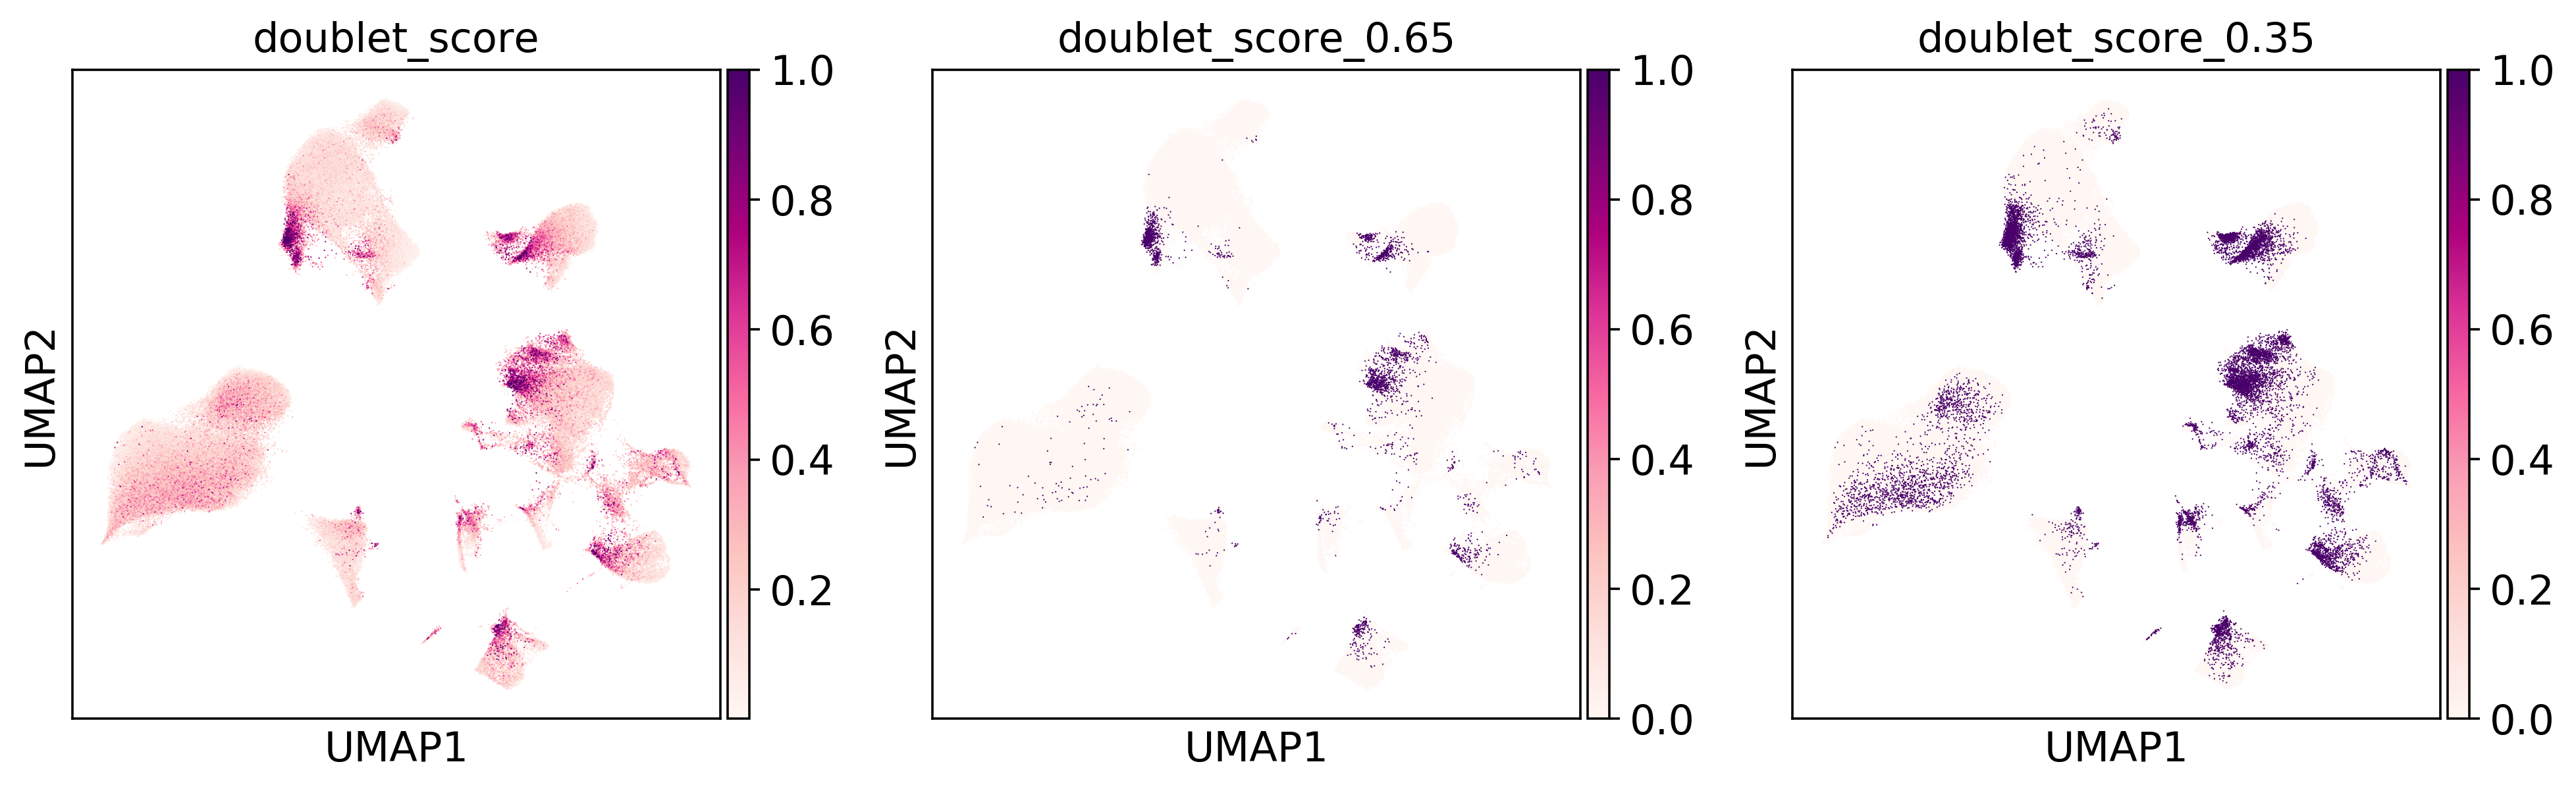

In [18]:
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
heart_hvg.obs['doublet_score_0.65'] = heart_hvg.obs['doublet_score'] > 0.65
heart_hvg.obs['doublet_score_0.35'] = heart_hvg.obs['doublet_score'] > 0.35
sc.pl.umap(heart_hvg, color = ['doublet_score', 'doublet_score_0.65', 'doublet_score_0.35'], size = 1, legend_fontsize = 6, color_map = 'RdPu')

In [19]:
print(heart_hvg.obs['doublet_score_0.35'].sum() / heart_hvg.shape[0])

0.06284928165770523


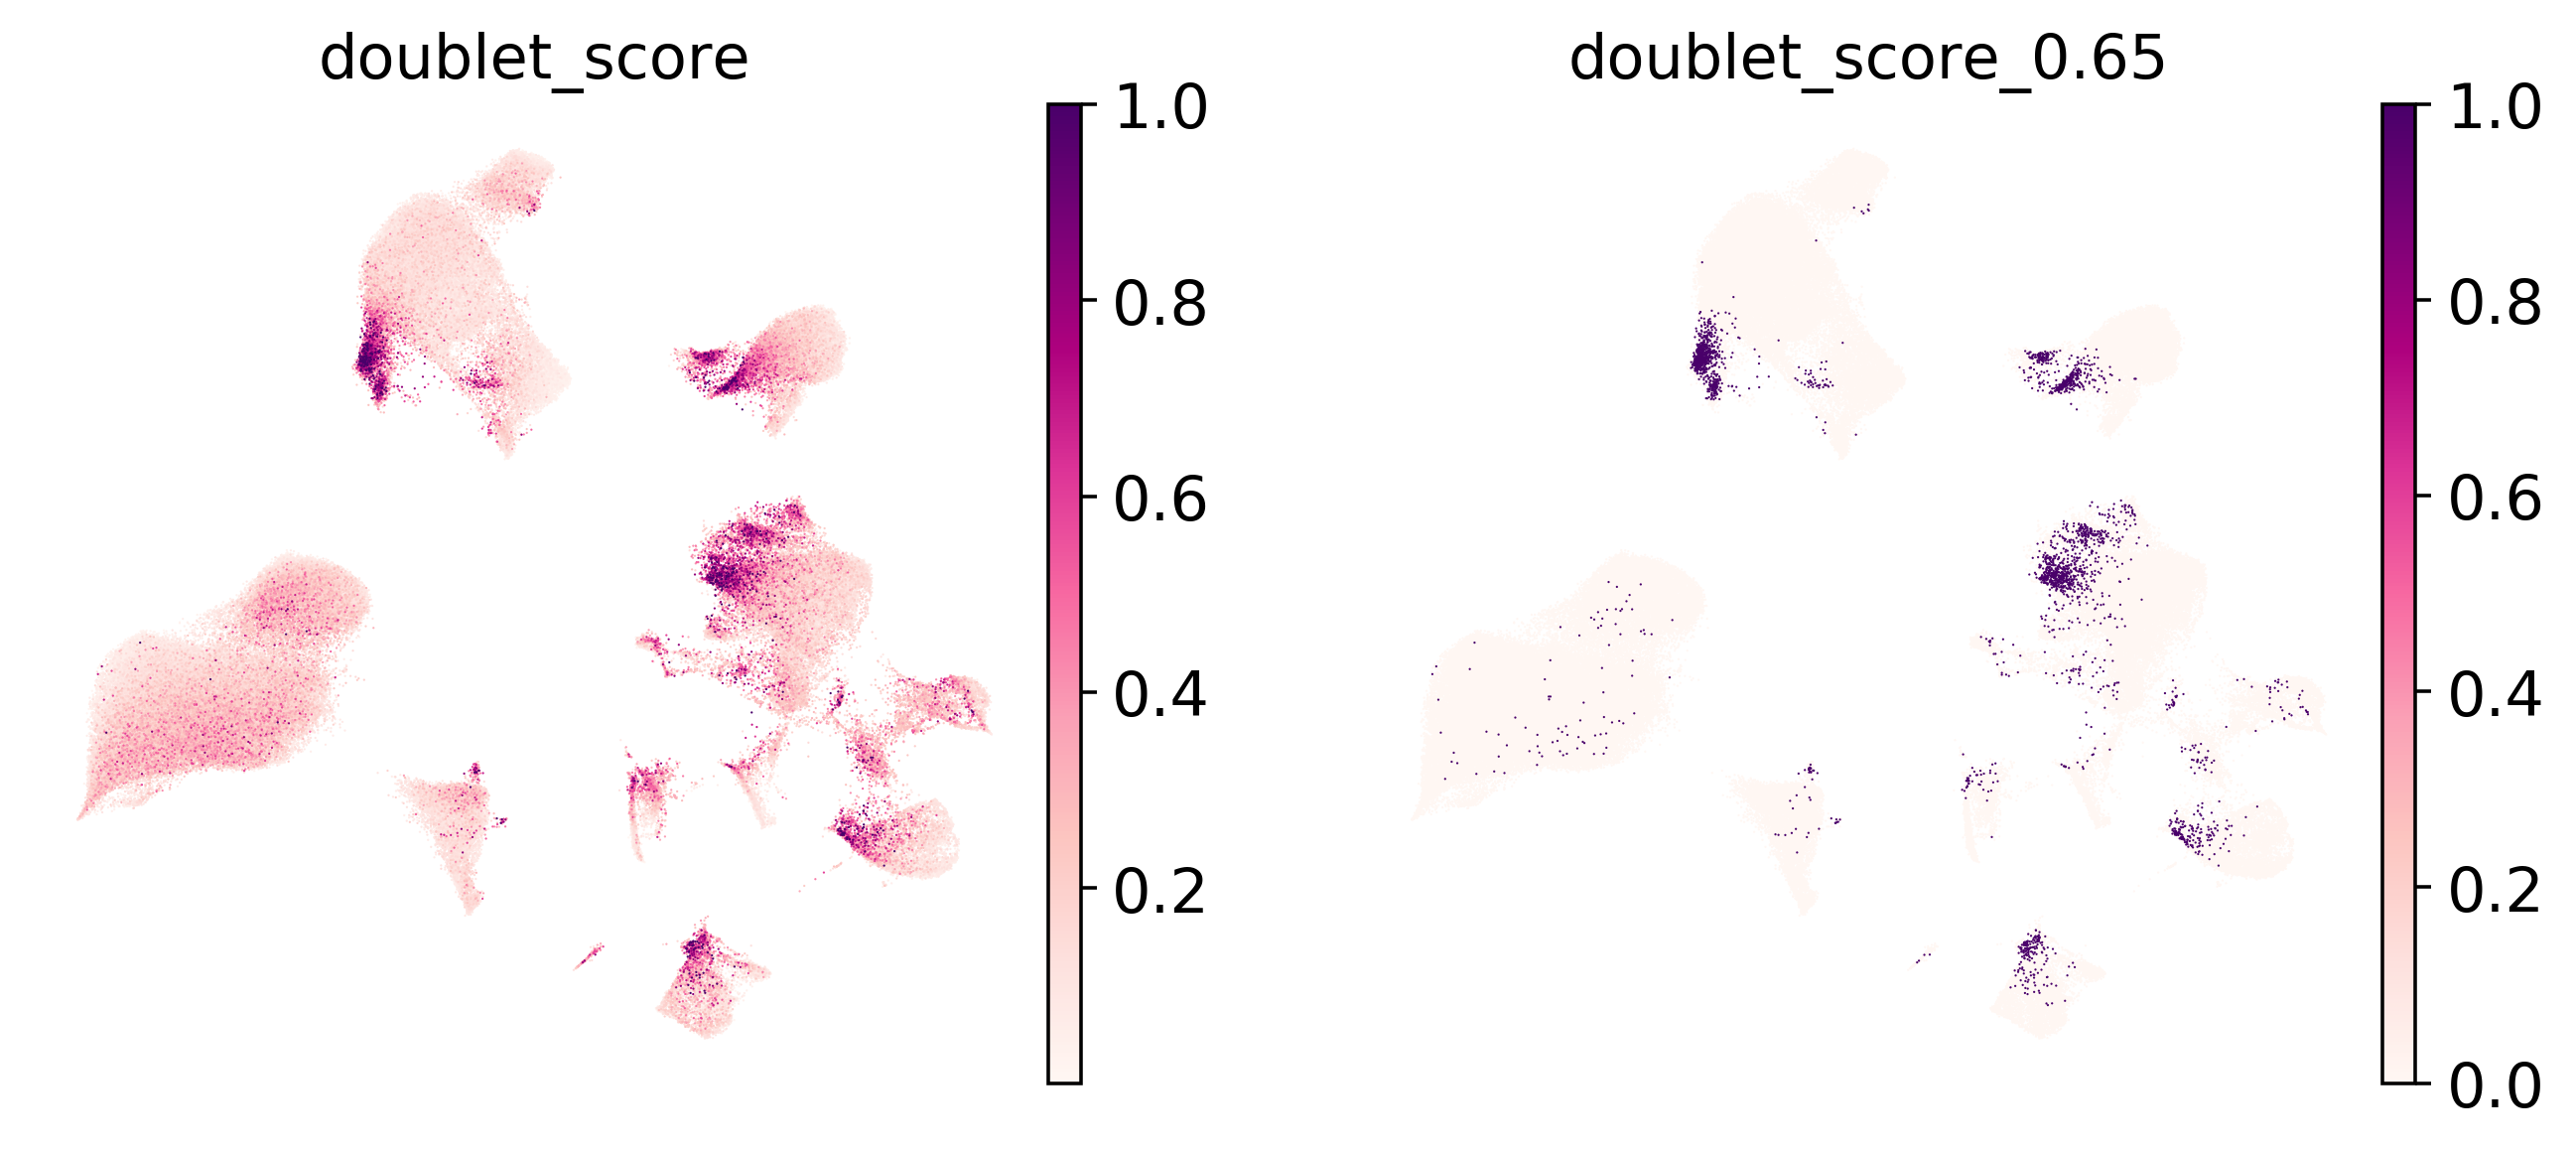

In [20]:
sc.pl.umap(heart_hvg, color = ['doublet_score','doublet_score_0.65'], size = 1, frameon = False, color_map = 'RdPu')

### Subset cells from raw data

In [21]:
data_raw = sample_object_backup[heart_hvg.obs_names]
data_raw.obs['scrublet_score'] = heart_hvg.obs['doublet_score']
data_raw

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 198443 × 33538 
    obs: 'NRP', 'age_group', 'batch', 'donor', 'gender', 'region', 'sample', 'source', 'type', 'version', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'scrublet_score'
    var: 'gene_ids', 'feature_types'

In [22]:
data_raw.write_h5ad('/home/jovyan/experiments/0-generate_anndata_objects/harvard_heart_NucSeq_QCed_scrublet_cellranger_ct200420.h5ad')